# 1. Setup

## 1.A Summary

## 1.B Libraries Import

In [ ]:
# === STANDARD LIBRARY ===
import json
import os
import pickle
import time
from datetime import datetime as dt, timezone as tz
import traceback

# === THIRD‑PARTY LIBRARIES ===
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from skorch import NeuralNetClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer
import glob
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# === PROJECT UTILITIES ===
from tools import Tools

## 1.C Invoke Classes

In [337]:
tools = Tools()

## 1.D Load Configuration

In [338]:
config = tools.load_toml_file("config.toml")
tools.print_message('success', 'Loaded configuration', format_dict={'number of keys': len(config)})

>>> [20:32:02] SUCCESS!: Loaded configuration NUMBER OF KEYS: 5

## 1.E Load the dataset

In [339]:
# Open dataset
# Realinho, V., Martins, M.V., Machado, J. and Baptista, L.M.T., 2021. Predict Students' Dropout and Academic Success. UCI Machine Learning Repository. Available at: https://doi.org/10.24432/C5MC89 [Accessed 31 May 2025].
df_dataset = tools.load_dataset(file_name='dataset_raw.csv')
df_dataset.head()

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nationality,mothers_qualification,fathers_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## 1.F Apply Target Binary Transformation

In [340]:
# Add a new target column with renamed values for one vs rest classification
df_dataset['target_binary'] = df_dataset['target'].map({'Dropout': 0, 'Graduate': 1, 'Enrolled': 1})
df_dataset['target_binary'].value_counts()

target_binary
1    3003
0    1421
Name: count, dtype: int64

## 1.G Data Shape Check

In [341]:
shape = df_dataset.shape
tools.print_message('success', 'Dataset loaded', format_dict={'rows': shape[0], 'columns': shape[1]})

>>> [20:32:02] SUCCESS!: Dataset loaded ROWS: 4424, COLUMNS: 38

## 1.H Create Directory to Save Models

In [342]:
models_dir = os.path.join(os.getcwd(), 'models')
models_performance_dir = os.path.join(os.getcwd(), 'models_performance')
dirs_to_create = [models_dir, models_performance_dir]
for d in dirs_to_create:
    if not os.path.exists(d):
        os.makedirs(d)


# 2. Feature Selection

## 2.A Summary

### <span style="color: #e74c3c;">**Feature Selection for Logistic Regression**</span>

This analysis prepared the dataset for Logistic Regression by removing problematic features and encoding categorical variables to create stable, interpretable predictors suitable for linear classification.

### <span style="color: #2E86AB;">**1. Feature Removal Strategy**</span>

**Removed 13 features** from original 36:
- **Data leakage**: 5 second semester features (students who withdraw early show zeros)
- **Severely imbalanced**: Nationality, educational special needs, international status (>97% in one category)
- **Zero information**: Daytime/evening attendance, displaced status
- **Weak predictors**: Economic indicators, previous qualification grade (correlation <0.10)

**Result**: 23 meaningful features suitable for linear classification.

### <span style="color: #2E86AB;">**2. High Cardinality Feature Engineering**</span>

**Parents' qualifications and occupations** (150+ total categories) were reduced to **2 binary indicators**:
- `parental_higher_education` - at least one parent with higher education
- `parental_professional_occupation` - at least one parent in professional role

**Benefits**: Captures family background whilst avoiding **coefficient inflation** from too many categories.

### <span style="color: #2E86AB;">**3. Withdrawal Rate Encoding**</span>

**Medium cardinality features** were replaced with their historical withdrawal rates:
- `application_mode` (18 categories) → `application_mode_withdrawal_rate`
- `course` (17 categories) → `course_withdrawal_rate` 
- `previous_qualification` (17 categories) → `previous_qualification_withdrawal_rate`

**Advantage**: Creates continuous predictors where higher values = higher risk, avoiding **sparse matrices** that harm model convergence.

### <span style="color: #2E86AB;">**4. One-Hot Encoding**</span>

**Low cardinality features** (2-8 categories) used **one-hot encoding** with `drop_first=True`:
- Marital status, application order, gender, scholarship holder, tuition fees status, debtor status
- Creates ~15 binary features
- **Drop-first prevents multicollinearity** - avoids perfect correlation between category indicators

### <span style="color: #e74c3c;">**Impact on Logistic Regression**</span>

**Model stability**: Strategic encoding prevents **multicollinearity** and **overfitting** whilst maintaining interpretable coefficients. **Early intervention capability**: Uses only first semester data for timely withdrawal prediction. **Regularisation ready**: 25 well-encoded features work effectively with **L1/L2 regularisation** techniques.

This feature selection balances predictive power with model stability, creating optimal conditions for Logistic Regression deployment in student retention systems.

## 2.B Features to Remove

In [343]:
# Data leakage - 2nd semester features
data_leakage_features = [
    'curricular_units_2nd_sem_credited',
    'curricular_units_2nd_sem_enrolled', 
    'curricular_units_2nd_sem_evaluations',
    'curricular_units_2nd_sem_approved',
    'curricular_units_2nd_sem_grade'
]

# Severely imbalanced features (>97% in one category)
imbalanced_features = [
    'nationality',
    'educational_special_needs',
    'international'
]

# Zero information value features
zero_info_features = [
    'daytime_evening_attendance',
    'displaced'
]

# Weak predictors (correlation < 0.10)
weak_predictors = [
    'unemployment_rate',
    'inflation_rate',
    'gdp',
    'previous_qualification_grade'
]

# Old target column
target_column = ['target']

# Combine all features to drop
features_to_drop = (data_leakage_features + 
                   imbalanced_features + 
                   zero_info_features + 
                   weak_predictors + 
                   target_column)

df_dataset.drop(columns=features_to_drop, inplace=True, errors='ignore')
tools.print_message('success', 'Dropped features', format_dict={'number of features': len(features_to_drop)})

>>> [20:32:03] SUCCESS!: Dropped features NUMBER OF FEATURES: 15

## 2.C Reduce High Cardinality Features

In [344]:
# Check if parental features still exist in dataset
parental_features = ['mothers_qualification', 'fathers_qualification', 'mothers_occupation', 'fathers_occupation']
existing_features = [f for f in parental_features if f in df_dataset.columns]
print(f"Remaining parental features: {existing_features}")

Remaining parental features: ['mothers_qualification', 'fathers_qualification', 'mothers_occupation', 'fathers_occupation']


In [345]:
# To reduce the number of categories in the parental qualification and occupation features, we will group them into broader categories.
def create_parental_higher_ed(df):
    """
    Creates binary indicator for parental higher education.
    Returns 1 if at least one parent has higher education, 0 otherwise.
    """
    higher_ed_codes = [2, 3, 4, 5, 6, 39, 40, 41, 42, 43, 44]
    
    mother_higher_ed = df['mothers_qualification'].isin(higher_ed_codes)
    father_higher_ed = df['fathers_qualification'].isin(higher_ed_codes)
    
    # At least one parent has higher education
    df['parental_higher_education'] = (mother_higher_ed | father_higher_ed).astype(int)
    df = df.drop(columns=['mothers_qualification', 'fathers_qualification'])
    
    return df

# Usage:
df_dataset = create_parental_higher_ed(df_dataset)
df_dataset.parental_higher_education.value_counts()

parental_higher_education
0    3616
1     808
Name: count, dtype: int64

In [346]:
def create_parental_professional_occupation(df):
    """
    Creates binary indicator for parental professional occupation.
    Returns 1 if at least one parent has professional/managerial role, 0 otherwise.
    """
    professional_codes = [1, 2, 3, 101, 102, 112, 114, 121, 122, 123, 124, 
                          131, 132, 134, 135]
    
    mother_professional = df['mothers_occupation'].isin(professional_codes)
    father_professional = df['fathers_occupation'].isin(professional_codes)
    
    # At least one parent has professional occupation
    df['parental_professional_occupation'] = (mother_professional | father_professional).astype(int)
    df = df.drop(columns=['mothers_occupation', 'fathers_occupation'])
    
    return df

# Usage:
df_dataset = create_parental_professional_occupation(df_dataset)
df_dataset.parental_professional_occupation.value_counts()

parental_professional_occupation
0    3270
1    1154
Name: count, dtype: int64

In [347]:
print(f"Dataset shape after parental feature engineering: {df_dataset.shape}")
print(f"Remaining features: {df_dataset.columns.tolist()}")

Dataset shape after parental feature engineering: (4424, 21)
Remaining features: ['marital_status', 'application_mode', 'application_order', 'course', 'previous_qualification', 'admission_grade', 'debtor', 'tuition_fees_up_to_date', 'gender', 'scholarship_holder', 'age_at_enrollment', 'curricular_units_1st_sem_credited', 'curricular_units_1st_sem_enrolled', 'curricular_units_1st_sem_evaluations', 'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade', 'curricular_units_1st_sem_without_evaluations', 'curricular_units_2nd_sem_without_evaluations', 'target_binary', 'parental_higher_education', 'parental_professional_occupation']


In [ ]:
def encode_categorical_withdrawal_rate(df, cat_col, target_col='target_binary'):
    """
    Replace categorical column with withdrawal rate encoding.
    
    Parameters:
    df: pandas DataFrame
    cat_col: name of categorical column to encode
    target_col: name of target column where 0=withdrawn
    
    Returns:
    pandas DataFrame with categorical column replaced by withdrawal_rate
    """
    
    df_encoded = df.copy()
    
    # Calculate withdrawal rate for each category
    withdrawal_rates = (df[target_col] == 0).groupby(df[cat_col]).mean()
    
    # Create new withdrawal rate column
    new_col_name = f'{cat_col.lower().replace(" ", "_")}_withdrawal_rate'
    df_encoded[new_col_name] = df[cat_col].map(withdrawal_rates)
    
    # Remove original column
    df_encoded = df_encoded.drop(columns=[cat_col])
    
    return df_encoded

# Usage:
df_dataset = encode_categorical_withdrawal_rate(df_dataset, 'application_mode')
df_dataset = encode_categorical_withdrawal_rate(df_dataset, 'course')
df_dataset = encode_categorical_withdrawal_rate(df_dataset, 'previous_qualification')
df_dataset.describe()

,marital_status,application_order,admission_grade,debtor,tuition_fees_up_to_date,gender,scholarship_holder,age_at_enrollment,curricular_units_1st_sem_credited,curricular_units_1st_sem_enrolled,...,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_without_evaluations,target_binary,parental_higher_education,parental_professional_occupation,application_mode_withdrawal_rate,course_withdrawal_rate,previous_qualification_withdrawal_rate
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,1.727848,126.978119,0.113698,0.880651,0.351718,0.248418,23.265145,0.709991,6.270570,...,4.706600,10.640822,0.137658,0.150316,0.678797,0.182640,0.260850,0.321203,0.321203,0.321203
std,0.605747,1.313793,14.482001,0.317480,0.324235,0.477560,0.432144,7.587816,2.360507,2.480178,...,3.094238,4.843663,0.690880,0.753774,0.466991,0.386415,0.439148,0.140266,0.121256,0.099940
min,1.000000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.154047,0.166667
25%,1.000000,1.000000,117.900000,0.000000,1.000000,0.000000,0.000000,19.000000,0.000000,5.000000,...,3.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.201991,0.183099,0.290019
50%,1.000000,1.000000,126.100000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,6.000000,...,5.000000,12.285714,0.000000,0.000000,1.000000,0.000000,0.000000,0.293578,0.330233,0.290019
75%,1.000000,2.000000,134.800000,0.000000,1.000000,1.000000,0.000000,25.000000,0.000000,7.000000,...,6.000000,13.400000,0.000000,0.000000,1.000000,0.000000,1.000000,0.368590,0.381395,0.290019
max,6.000000,9.000000,190.000000,1.000000,1.000000,1.000000,1.000000,70.000000,20.000000,26.000000,...,26.000000,18.875000,12.000000,12.000000,1.000000,1.000000,1.000000,1.000000,0.666667,1.000000


In [ ]:
def one_hot_encode_features(df, categorical_columns):
    """
    One-hot encode specified categorical columns.
    
    Parameters:
    df: pandas DataFrame
    categorical_columns: list of column names to encode
    
    Returns:
    pandas DataFrame with categorical columns one-hot encoded
    """
    
    # Check which features actually exist in the dataset
    existing_categorical = [col for col in categorical_columns if col in df.columns]
    missing_categorical = [col for col in categorical_columns if col not in df.columns]
    
    if missing_categorical:
        print(f"Warning: These columns not found in dataset: {missing_categorical}")
    
    print(f"Categorical features to encode: {existing_categorical}")
    
    # One-hot encode with drop_first=True to avoid multicollinearity
    df_encoded = pd.get_dummies(df, 
                               columns=existing_categorical, 
                               drop_first=True, 
                               dtype=int)
    
    print(f"Shape before encoding: {df.shape}")
    print(f"Shape after encoding: {df_encoded.shape}")
    print(f"Features added: {df_encoded.shape[1] - df.shape[1]}")
    
    # Show new encoded column names
    new_columns = [col for col in df_encoded.columns if any(cat in col for cat in existing_categorical)]
    print(f"New encoded features: {new_columns}")
    
    return df_encoded

# Usage:
remaining_categorical = [
    'marital_status',
    'application_order',  
    'gender',
    'scholarship_holder',
    'tuition_fees_up_to_date',
    'debtor'
]

df_dataset = one_hot_encode_features(df_dataset, remaining_categorical)

Categorical features to encode: ['marital_status', 'application_order', 'gender', 'scholarship_holder', 'tuition_fees_up_to_date', 'debtor']
Shape before encoding: (4424, 21)
Shape after encoding: (4424, 31)
Features added: 10
New encoded features: ['marital_status_2', 'marital_status_3', 'marital_status_4', 'marital_status_5', 'marital_status_6', 'application_order_1', 'application_order_2', 'application_order_3', 'application_order_4', 'application_order_5', 'application_order_6', 'application_order_9', 'gender_1', 'scholarship_holder_1', 'tuition_fees_up_to_date_1', 'debtor_1']


# 3. Processing Pipeline

## 3.A Summary

### <span style="color: #e74c3c;">**Logistic Regression Processing Pipeline Summary**</span>

This section implemented a modular processing pipeline for logistic regression, separating train/test splitting and feature scaling into distinct functions to prevent data leakage and ensure proper workflow.

### <span style="color: #2E86AB;">**1. Two-Function Design**</span>

**Modular approach** improved maintainability:
- `create_train_test_split_logistic()` - handles stratified 80/20 data splitting
- `scale_features_logistic()` - applies configurable feature scaling

**Benefits**: **Single responsibility principle** ensures each function performs one task, **reusable components** work with different configurations, **flexible parameters** enable easy adjustments.

### <span style="color: #2E86AB;">**2. Critical Workflow Order**</span>

**Split first, scale second** prevents **data leakage**. **Data leakage** occurs when test set information influences preprocessing, creating artificially optimistic performance estimates.

**Correct sequence:**
1. Split data (training/test)
2. Fit scaler on training data only  
3. Apply same scaler to test data

**Why this matters**: Scaling before splitting would use test set statistics, compromising model evaluation reliability.

### <span style="color: #2E86AB;">**3. Results Achieved**</span>

**Perfect stratification**: Both training (3,539 samples) and test (885 samples) maintain identical 67.9%/32.1% class distributions.

**Configurable scaling** via `scaler_type` parameter enables easy comparison testing between `standard`, `minmax`, and `none` options. **StandardScaler preferred for logistic regression** because linear models like logistic regression initialise weights to 0 or small random values, making standardised features (mean=0, std=1) easier to learn. StandardScaler is particularly important when using regularisation, as it ensures fair penalty application across all features, preventing features with larger scales from dominating the model coefficients.

### <span style="color: #e74c3c;">**Pipeline Outcome**</span>

The pipeline produces **deployment-ready data** (X_train_scaled, X_test_scaled, y_train, y_test, scaler) whilst preventing data leakage and ensuring reliable model evaluation. **Modular design** enables easy debugging and configuration adjustments for optimal logistic regression performance.

## 3.B Train Test Split

In [350]:
def create_train_test_split_logistic(X_features, df_dataset, logistic_config):
    """Create stratified train/test split for logistic regression."""
    
    # Define target variable y
    y = df_dataset['target_binary']

    # Get required parameters with defaults
    train_size = logistic_config.get('train_size', 0.8)
    use_stratify = logistic_config.get('stratify', True)
    
    # Handle random state
    random_state_config = logistic_config.get('random_state', 42)
    if random_state_config == "random":
        random_state = np.random.randint(0, 10000)
        print(f"Generated random seed for train/test split: {random_state}")
    else:
        random_state = int(random_state_config)

    # Set stratify parameter
    stratify_param = y if use_stratify else None

    # Perform train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_features,
        y,
        train_size=train_size,
        random_state=random_state,  # Use processed random_state
        stratify=stratify_param
    )

    # Print split information
    print(f'Training set: {len(X_train)} samples ({train_size*100:.0f}%)')
    print(f'Test set: {len(X_test)} samples ({(1-train_size)*100:.0f}%)')

    if use_stratify:
        print(f'Training class distribution: {y_train.value_counts(normalize=True).round(3).to_dict()}')
        print(f'Test class distribution: {y_test.value_counts(normalize=True).round(3).to_dict()}')

    return X_train, X_test, y_train, y_test

In [351]:
# Create train/test split
logistic_config = config.get('logistic_regression_model') 
X_features = df_dataset.drop('target_binary', axis=1)

# Split the data
X_train, X_test, y_train, y_test = create_train_test_split_logistic(
    X_features, df_dataset, logistic_config
)

Training set: 3539 samples (80%)
Test set: 885 samples (20%)
Training class distribution: {1: 0.679, 0: 0.321}
Test class distribution: {1: 0.679, 0: 0.321}


In [352]:
def scale_features_logistic(X_train, X_test, logistic_config):
    """
    Scale features using specified scaling method.
    
    Parameters:
    X_train: Training feature matrix
    X_test: Test feature matrix
    logistic_config: Logistic regression configuration dictionary
    
    Returns:
    tuple: X_train_scaled, X_test_scaled, scaler
    """
    
    # Get scaling method
    scaler_type = logistic_config.get('scaler_type', 'standard')
    
    # Validate scaler type
    if scaler_type not in ['standard', 'minmax', 'none']:
        raise ValueError(f'scaler_type must be "standard", "minmax", or "none", got {scaler_type}')

    # Create scaler
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    else:  # scaler_type == 'none'
        scaler = None

    # Apply scaling
    if scaler is not None:
        # Fit scaler on training data only
        X_train_scaled = scaler.fit_transform(X_train)
        # Apply same scaler to test data (no re-fitting)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    print(f'Scaling method applied: {scaler_type}')
    
    return X_train_scaled, X_test_scaled, scaler

# Scale the features
X_train_scaled, X_test_scaled, scaler = scale_features_logistic(
    X_train, X_test, logistic_config
)

Scaling method applied: standard


## 4. Model Training

## 4.A Summary

## 4.B Create the Model

In [353]:
class LogisticRegressionNet(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, 1)
    
    def forward(self, x):
        logit = self.linear(x).squeeze()
        prob_class_1 = torch.sigmoid(logit)  # Probability of class 1
        prob_class_0 = 1 - prob_class_1      # Probability of class 0
        
        # Stack to create [prob_class_0, prob_class_1] for each sample
        return torch.stack([prob_class_0, prob_class_1], dim=1)

In [354]:
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight=1.0):
        super().__init__()
        self.pos_weight = pos_weight
    
    def forward(self, input, target):
        # input is now shape (batch_size, 2)
        # Extract probability of class 1 (second column)
        prob_class_1 = input[:, 1]
        
        # Convert pos_weight to tensor if needed
        if not isinstance(self.pos_weight, torch.Tensor):
            pos_weight = torch.tensor(self.pos_weight, device=input.device)
        else:
            pos_weight = self.pos_weight
            
        # Apply weighted BCE loss
        loss = -(target * pos_weight * torch.log(prob_class_1 + 1e-8) + 
                (1 - target) * torch.log(1 - prob_class_1 + 1e-8))
        return loss.mean()

In [ ]:
def create_withdrawal_recall_scorer():
    """
    Creates custom scorer for withdrawal recall (recall for class 0).
    This measures how well the model catches students who will withdraw.
    """
    
    # Recall for class 0 (withdrawal)
    withdrawal_recall_scorer = make_scorer(
        recall_score, 
        pos_label=0,  # Focus on class 0 (withdrawal)
        average='binary'
    )
    
    return withdrawal_recall_scorer

In [356]:
def setup_pytorch_logistic_regression_from_config(config, X_train, device='cuda', param_profile='pytorch_logistic_regression_quick'):
    """Setup PyTorch logistic regression with grid search"""
    pytorch_config = config[param_profile]
    input_dim = X_train.shape[1]
    
    # Handle random state
    random_state_config = pytorch_config['random_state']
    if random_state_config == "random":
        random_state = np.random.randint(0, 10000)
        print(f"Generated random seed: {random_state}")
    else:
        random_state = int(random_state_config)
        print(f"Using fixed seed: {random_state}")
    
    # Device setup
    if device == 'cuda' and not torch.cuda.is_available():
        device = 'cpu'
    
    # Create model
    model = NeuralNetClassifier(
        LogisticRegressionNet,
        module__input_dim=input_dim,
        criterion=WeightedBCELoss,
        optimizer=torch.optim.Adam,
        lr=0.01,
        max_epochs=50,
        batch_size=32,
        device=device,
        train_split=None,
        verbose=0,
    )
    
    # Parameter grid
    param_grid = {
        'lr': pytorch_config['lr_values'],
        'max_epochs': pytorch_config['max_epochs_values'],
        'optimizer__weight_decay': pytorch_config['weight_decay_values'],
        'batch_size': pytorch_config['batch_size_values'],
        'criterion__pos_weight': pytorch_config['class_weights']
    }
    
    # CV strategy with generated/configured random state
    cv_strategy = StratifiedKFold(
        n_splits=pytorch_config['cv_folds'],
        shuffle=True,
        random_state=random_state  # Use the processed random_state
    )
    
    # Rest of function remains the same...
    scoring_metric = pytorch_config['scoring_metric']
    if scoring_metric == 'withdrawal_recall':
        scorer = create_withdrawal_recall_scorer()
    else:
        scorer = scoring_metric
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_strategy,
        scoring=scorer,
        n_jobs=1,
        verbose=1
    )
    
    return grid_search

In [357]:
def save_pytorch_model_with_timestamp(grid_search, models_dir, scaler, feature_columns, scoring_metric):
    """Save PyTorch model with performance score formatted for easy sorting"""
    timestamp = dt.now(tz=tz.utc).strftime("%y%m%d-%H%M%S")
    
    # Format score as integer (multiply by 10000 for 4 decimal precision)
    score_int = int(grid_search.best_score_ * 10000)
    
    model_name = f"LR_model_{timestamp}_s{score_int:04d}"
    # Example: LR_model_250605-121826_s5740 (represents 0.5740)
    
    # Create model directory
    model_dir = os.path.join(models_dir, model_name)
    os.makedirs(model_dir, exist_ok=True)
    
    # Save model weights
    model_path = os.path.join(model_dir, f"{model_name}.pth")
    torch.save(grid_search.best_estimator_.module_.state_dict(), model_path)
    
    # Save scaler and features
    pickle.dump(scaler, open(os.path.join(model_dir, "scaler.pkl"), 'wb'))
    pickle.dump(feature_columns, open(os.path.join(model_dir, "features.pkl"), 'wb'))
    
    # Save metadata with score info
    metadata = {
        'best_score': grid_search.best_score_,
        'scoring_metric': scoring_metric,
        'best_params': grid_search.best_params_,
        'timestamp': timestamp
    }
    with open(os.path.join(model_dir, "metadata.json"), 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Model saved: {model_name}")
    print(f"Best {scoring_metric}: {grid_search.best_score_:.4f}")
    
    return model_path, os.path.join(model_dir, "metadata.json")

In [ ]:
def load_best_pytorch_model(models_dir):
    """
    Load the PyTorch model with the highest score from the models directory.
    
    Returns:
        tuple: (best_model, best_metadata, loaded_scaler, loaded_feature_columns) or None if no models found
    """
    
    # Find all model directories
    pattern = os.path.join(models_dir, "LR_model_*_s*")
    model_dirs = glob.glob(pattern)
    
    if not model_dirs:
        print("No saved models found")
        return None
    
    # Extract scores from directory names and find the best one
    best_score = -1
    best_dir = None
    
    for model_dir in model_dirs:
        dir_name = os.path.basename(model_dir)
        match = re.search(r's(\d{4})', dir_name)
        if match:
            score = int(match.group(1))
            if score > best_score:
                best_score = score
                best_dir = model_dir
    
    if best_dir is None:
        print("No valid model scores found in filenames")
        return None
    
    print(f"Loading best model: {os.path.basename(best_dir)} (score: {best_score/10000:.4f})")
    
    try:
        # Load metadata
        print("Loading metadata...")
        metadata_path = os.path.join(best_dir, "metadata.json")
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        # Load scaler
        print("Loading scaler...")
        scaler_path = os.path.join(best_dir, "scaler.pkl")
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        
        # Load feature columns
        print("Loading feature columns...")
        features_path = os.path.join(best_dir, "features.pkl")
        with open(features_path, 'rb') as f:
            feature_columns = pickle.load(f)
        
        print(f"Feature count: {len(feature_columns)}")
        
        # Reconstruct the model with SAME criterion as training
        print("Reconstructing model...")
        input_dim = len(feature_columns)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device: {device}")
        
        # Get pos_weight from metadata if available
        best_params = metadata['best_params']
        pos_weight = best_params.get('criterion__pos_weight', 1.0)
        
        # Create the NeuralNetClassifier with SAME parameters as training
        model = NeuralNetClassifier(
            LogisticRegressionNet,
            module__input_dim=input_dim,
            criterion=WeightedBCELoss,  # ← FIXED: Use same criterion as training
            criterion__pos_weight=pos_weight,  # ← FIXED: Use same pos_weight
            optimizer=torch.optim.Adam,
            lr=best_params.get('lr', 0.01),
            max_epochs=best_params.get('max_epochs', 50),
            batch_size=best_params.get('batch_size', 32),
            optimizer__weight_decay=best_params.get('optimizer__weight_decay', 0),  # ← FIXED: Add weight_decay
            device=device,
            train_split=None,
            verbose=0,
        )
        
        # Initialize the model structure without training
        print("Initializing model structure...")
        model.initialize()
        
        # Load the saved weights
        print("Loading model weights...")
        model_filename = os.path.basename(best_dir) + ".pth"
        model_path = os.path.join(best_dir, model_filename)
        
        state_dict = torch.load(model_path, map_location=device)
        model.module_.load_state_dict(state_dict)
        
        print(f"Successfully loaded model with {metadata['scoring_metric']}: {metadata['best_score']:.4f}")
        print(f"Model criterion: WeightedBCELoss with pos_weight={pos_weight}")
        
        return model, metadata, scaler, feature_columns
        
    except Exception as e:
        print(f"Error loading model from {best_dir}: {str(e)}")
        traceback.print_exc()
        return None

In [ ]:
def save_model_data_to_csv(model_name, timestamp, training_time_seconds, best_cv_score,  # Changed parameter name
                          test_accuracy, test_precision, test_recall, test_f1_score, 
                          test_specificity, true_positives, false_positives, 
                          true_negatives, false_negatives, best_parameters, param_profile,
                          threshold, config_settings, models_performance_dir):
    """
    Save model performance data to CSV file in models_performance directory.
    Creates file if it doesn't exist, appends if it does.
    Rounds float values to 4 decimal places.
    """
    
    # Define CSV file path
    csv_path = os.path.join(models_performance_dir, 'model_performance_log.csv')
    
    # Create new row of data
    new_row = {
        'model_name': model_name,
        'timestamp': timestamp,
        'training_time_seconds': training_time_seconds,
        'best_cv_score': best_cv_score,  # Changed column name to be generic
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1_score': test_f1_score,
        'test_specificity': test_specificity,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'true_negatives': true_negatives,
        'false_negatives': false_negatives,
        'best_parameters': str(best_parameters),
        'param_profile': param_profile,
        'threshold': threshold,
        'config_settings': str(config_settings)
    }
    
    # Round float values to 4 decimal places
    for key, value in new_row.items():
        if isinstance(value, float):
            new_row[key] = round(value, 4)
    
    # Convert to DataFrame
    new_df = pd.DataFrame([new_row])
    
    # Check if CSV exists
    if os.path.exists(csv_path):
        new_df.to_csv(csv_path, mode='a', header=False, index=False)
        print(f'Appended model data to {csv_path}')
    else:
        new_df.to_csv(csv_path, mode='w', header=True, index=False)
        print(f'Created new performance log: {csv_path}')
    
    return csv_path

In [ ]:
def train_model(X_train_scaled, y_train, X_test_scaled, y_test, X_train, 
                config, scaler, models_dir, models_performance_dir,
                train_new_model=True, param_profile='pytorch_logistic_regression_testing'):
    """
    Train or load PyTorch logistic regression model for student withdrawal prediction.
    
    Returns:
        tuple: (best_model, y_pred, y_pred_proba)
    """
    
    # Get threshold from config
    threshold = config[param_profile].get('threshold', 0.5)
    
    # Get config settings for logging
    config_settings = config[param_profile].copy()
    
    # Data preparation - ensure consistent data types
    X_train_clean = np.array(X_train_scaled, dtype=np.float32)
    y_train_clean = np.array(y_train, dtype=np.int32)
    X_test_clean = np.array(X_test_scaled, dtype=np.float32)
    y_test_clean = np.array(y_test, dtype=np.int32)
    feature_columns = X_train.columns.tolist()

    # Train or load model
    if train_new_model:
        print('Training new model...')
        start_time = time.time()
        
        grid_search = setup_pytorch_logistic_regression_from_config(
            config, X_train_clean, device='cuda', param_profile=param_profile
        )
        grid_search.fit(X_train_clean, y_train_clean.astype(np.float32))
        
        training_time_seconds = time.time() - start_time
        
        # Save model
        model_path, metadata_path = save_pytorch_model_with_timestamp(
            grid_search, models_dir, scaler, feature_columns, 
            config[param_profile]['scoring_metric']
        )
        
        best_model = grid_search.best_estimator_
        best_cv_score = grid_search.best_score_
        best_parameters = grid_search.best_params_
        timestamp = dt.now(tz=tz.utc).strftime("%y%m%d-%H%M%S")
        model_name = os.path.basename(os.path.dirname(model_path))

    else:
        print('Loading existing model...')
        result = load_best_pytorch_model(models_dir)
        if result is None:
            raise FileNotFoundError('No existing model found')
        best_model, best_metadata, loaded_scaler, loaded_feature_columns = result
        
        # For loaded models, set these variables for consistency
        training_time_seconds = 0  # No training time for loaded models
        best_cv_score = best_metadata['best_score']
        best_parameters = best_metadata['best_params']
        timestamp = best_metadata['timestamp']
        model_name = f"LR_model_{timestamp}_s{int(best_cv_score * 10000):04d}"

    # Prediction process (same for both trained and loaded models)
    print(f"Using classification threshold: {threshold}")
    
    try:
        # Get raw predictions - should be (n_samples, 2)
        y_pred_proba_raw = best_model.predict_proba(X_test_clean)
        print(f"Raw prediction shape: {y_pred_proba_raw.shape}")
        
        # Extract probabilities for class 1 (continuation)
        if len(y_pred_proba_raw.shape) == 2 and y_pred_proba_raw.shape[1] == 2:
            y_pred_proba = y_pred_proba_raw[:, 1]
        else:
            raise ValueError(f"Unexpected prediction shape: {y_pred_proba_raw.shape}")
        
        # Apply threshold
        y_pred = (y_pred_proba >= threshold).astype(np.int32)
        
        print(f"Prediction probabilities range: {y_pred_proba.min():.3f} to {y_pred_proba.max():.3f}")
        print(f"Predicted to continue: {np.sum(y_pred)} students")
        print(f"Predicted to withdraw: {len(y_pred) - np.sum(y_pred)} students")
        
        # Calculate metrics (same for both cases)
        test_accuracy = accuracy_score(y_test_clean, y_pred)
        test_precision = precision_score(y_test_clean, y_pred, zero_division=0)
        test_recall = recall_score(y_test_clean, y_pred, zero_division=0)
        test_f1_score = f1_score(y_test_clean, y_pred, zero_division=0)
        
        # Calculate confusion matrix values
        cm = confusion_matrix(y_test_clean, y_pred)
        tn, fp, fn, tp = cm.ravel()
        test_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        traceback.print_exc()
        raise
    
    # Save performance data to CSV (ONLY for newly trained models)
    if train_new_model:
        save_model_data_to_csv(
            model_name=model_name,
            timestamp=timestamp,
            training_time_seconds=training_time_seconds,
            best_cv_score=best_cv_score,
            test_accuracy=test_accuracy,
            test_precision=test_precision,
            test_recall=test_recall,
            test_f1_score=test_f1_score,
            test_specificity=test_specificity,
            true_positives=tp,
            false_positives=fp,
            true_negatives=tn,
            false_negatives=fn,
            best_parameters=best_parameters,
            param_profile=param_profile,
            threshold=threshold,
            config_settings=config_settings,
            models_performance_dir=models_performance_dir
        )
    
    return best_model, y_pred, y_pred_proba, model_name

In [361]:
# Get the model
param_profile = 'pytorch_logistic_regression_testing'
python_logistic_config = config[param_profile]

model, predictions, probabilities, model_name = train_model(
    X_train_scaled, y_train, X_test_scaled, y_test, X_train,
    config, scaler, models_dir=models_dir, models_performance_dir=models_performance_dir,
    train_new_model=True, param_profile=param_profile
)

Training new model...
Generated random seed: 1189
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Model saved: LR_model_250605-203351_s6701
Best withdrawal_recall: 0.6702
Using classification threshold: 0.65
Raw prediction shape: (885, 2)
Prediction probabilities range: 0.001 to 0.991
Predicted to continue: 609 students
Predicted to withdraw: 276 students
Appended model data to c:\Users\Craig\Documents\Python\msc_ai_module\models_performance\model_performance_log.csv


## 4.C Model Evaluation

📋 Using threshold from config [pytorch_logistic_regression_testing]: 0.65

LR_MODEL_250605-203351_S6701 PERFORMANCE ANALYSIS
Threshold: 0.65

KEY PERFORMANCE METRICS:
                  Metric Value
                Accuracy 0.855
               Precision 0.888
    Recall (Sensitivity) 0.900
                F1-Score 0.894
Specificity (Withdrawal) 0.761

BUSINESS IMPACT ANALYSIS:
                              Metric           Value
Total students who actually withdrew             284
    Correctly identified withdrawals             216
Missed withdrawals (critical errors)              68
           Withdrawal Detection Rate 76.1% (216/284)
Students needing intervention caught             216
             At-risk students missed              68

SUMMARY:
🟢 Model Performance: EXCELLENT
📊 Withdrawal Detection: 76.1% (216 out of 284 students)
⚠️  Missed Interventions: 68 students requiring support


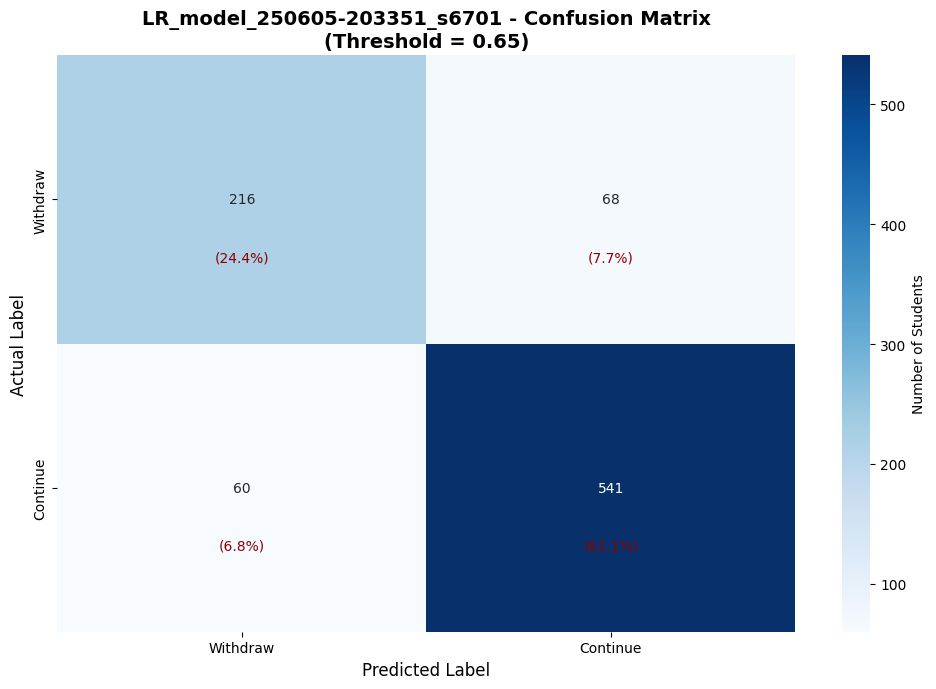


🎯 KEY RESULT: Withdrawal Detection Rate = 76.1%


In [ ]:
def analyse_confusion_matrix(y_test, predictions, model_name="Logistic Regression", threshold=0.7, show_plot=True):
    """
    Analyse confusion matrix for binary classification with withdrawal focus.
    
    Parameters:
    y_test: True labels (0=withdrawal, 1=continuation)
    predictions: Predicted labels (0=withdrawal, 1=continuation)
    model_name: Name of the model being evaluated
    threshold: Classification threshold used
    show_plot: Whether to display the heatmap
    
    Returns:
    dict: Dictionary containing key metrics
    """
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate additional metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, zero_division=0)
    recall = recall_score(y_test, predictions, zero_division=0)
    f1 = f1_score(y_test, predictions, zero_division=0)
    
    # Business interpretation
    total_withdrawals = tn + fp
    total_continuations = fn + tp
    withdrawal_recall = tn / total_withdrawals if total_withdrawals > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\n{model_name.upper()} PERFORMANCE ANALYSIS")
    print("=" * 60)
    print(f"Threshold: {threshold}")
    
    # Key Metrics DataFrame
    print("\nKEY PERFORMANCE METRICS:")
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall (Sensitivity)', 'F1-Score', 'Specificity (Withdrawal)'],
        'Value': [f"{accuracy:.3f}", f"{precision:.3f}", f"{recall:.3f}", f"{f1:.3f}", f"{specificity:.3f}"]
    })
    print(metrics_df.to_string(index=False))
    
    # Business Impact DataFrame
    print("\nBUSINESS IMPACT ANALYSIS:")
    business_df = pd.DataFrame({
        'Metric': [
            'Total students who actually withdrew',
            'Correctly identified withdrawals', 
            'Missed withdrawals (critical errors)',
            'Withdrawal Detection Rate',
            'Students needing intervention caught',
            'At-risk students missed'
        ],
        'Value': [
            total_withdrawals,
            tn,
            fp,
            f"{withdrawal_recall:.1%} ({tn}/{total_withdrawals})",
            tn,
            fp
        ]
    })
    print(business_df.to_string(index=False))
    
    # Summary
    print("\nSUMMARY:")
    if withdrawal_recall >= 0.70:
        performance = "EXCELLENT"
        color = "🟢"
    elif withdrawal_recall >= 0.60:
        performance = "GOOD" 
        color = "🟡"
    elif withdrawal_recall >= 0.50:
        performance = "FAIR"
        color = "🟠"
    else:
        performance = "POOR"
        color = "🔴"
    
    print(f"{color} Model Performance: {performance}")
    print(f"📊 Withdrawal Detection: {withdrawal_recall:.1%} ({tn} out of {total_withdrawals} students)")
    print(f"⚠️  Missed Interventions: {fp} students requiring support")
    
    # Visual confusion matrix
    if show_plot:
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Withdraw', 'Continue'], 
                    yticklabels=['Withdraw', 'Continue'],
                    cbar_kws={'label': 'Number of Students'})
        plt.title(f'{model_name} - Confusion Matrix\n(Threshold = {threshold})', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('Actual Label', fontsize=12)
        
        # Add percentage annotations
        total_samples = cm.sum()
        for i in range(2):
            for j in range(2):
                percentage = cm[i, j] / total_samples * 100
                plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                        ha='center', va='center', fontsize=10, color='darkred')
        
        plt.tight_layout()
        plt.show()
    
    # Return key metrics
    return {
        'confusion_matrix': cm,
        'true_negatives': tn,
        'false_positives': fp, 
        'false_negatives': fn,
        'true_positives': tp,
        'withdrawal_recall': withdrawal_recall,
        'total_withdrawals': total_withdrawals,
        'total_continuations': total_continuations,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity
    }


# Get the actual threshold from config
param_profile = 'pytorch_logistic_regression_testing'
actual_threshold = config[param_profile].get('threshold', 0.5)

print(f"📋 Using threshold from config [{param_profile}]: {actual_threshold}")

# Use the correct threshold from config
results = analyse_confusion_matrix(y_test, predictions, 
                                  model_name=model_name, 
                                  threshold=actual_threshold)

print(f"\n🎯 KEY RESULT: Withdrawal Detection Rate = {results['withdrawal_recall']:.1%}")

📋 Using threshold from config [pytorch_logistic_regression_testing]: 0.65
Added config threshold 0.65 to analysis range


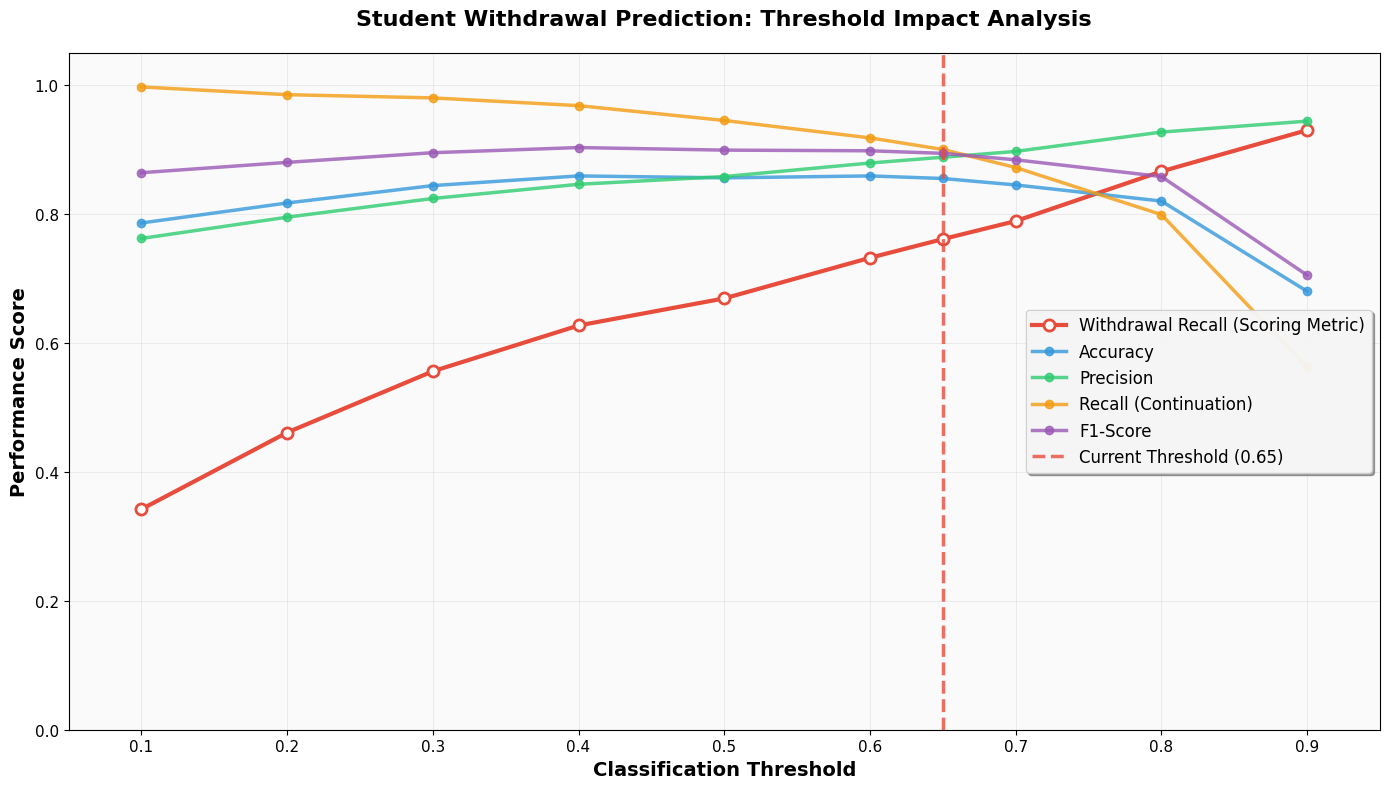

📊 THRESHOLD ANALYSIS SUMMARY
🎯 Best Withdrawal Recall: 0.930 at threshold 0.9
📈 Best Overall Accuracy: 0.859 at threshold 0.4
⚙️  Current Performance (0.65): Withdrawal Recall = 0.761


In [ ]:
def analyse_threshold_impact_with_plot(model, X_test, y_test, config, param_profile, 
                                     probabilities=None, threshold_range=(0.1, 0.9, 0.1)):
    """
    Analyse and visualise how different threshold values affect model performance.
    
    Parameters:
    model: Trained model
    X_test: Test features
    y_test: Test labels
    config: Configuration dictionary
    param_profile: Configuration profile name (e.g., 'pytorch_logistic_regression_testing')
    probabilities: Pre-computed probabilities (optional)
    threshold_range: (start, stop, step) for threshold values
    
    Returns:
    DataFrame with metrics for each threshold
    """
    
    # Get current threshold from config
    current_threshold = config[param_profile].get('threshold', 0.5)
    print(f"📋 Using threshold from config [{param_profile}]: {current_threshold}")
    
    # Get probabilities if not provided
    if probabilities is None:
        probabilities = model.predict_proba(X_test)[:, 1]
    
    # Create threshold range
    start, stop, step = threshold_range
    thresholds = np.arange(start, stop + step, step)
    
    # Ensure current_threshold is included in the analysis
    if current_threshold not in thresholds:
        thresholds = np.append(thresholds, current_threshold)
        thresholds = np.sort(thresholds)
        print(f"Added config threshold {current_threshold} to analysis range")
    
    results = []
    
    for threshold in thresholds:
        # Apply threshold
        y_pred = (probabilities >= threshold).astype(int)
        
        # Calculate standard metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        
        # Calculate withdrawal recall (the scoring metric used in training)
        withdrawal_recall = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
        
        # Calculate confusion matrix values
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'precision': precision, 
            'recall': recall,
            'f1_score': f1,
            'withdrawal_recall': withdrawal_recall,
            'withdrawals_caught': tn,
            'withdrawals_missed': fp
        })
    
    # Create DataFrame
    df_results = pd.DataFrame(results).round(3)
    
    # Create professional-looking plot
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Define professional color palette
    colors = {
        'withdrawal_recall': '#E74C3C',  # Red - most important metric
        'accuracy': '#3498DB',           # Blue 
        'precision': '#2ECC71',          # Green
        'recall': '#F39C12',             # Orange
        'f1_score': '#9B59B6'            # Purple
    }
    
    # Plot metrics with enhanced styling
    for metric, color in colors.items():
        if metric == 'withdrawal_recall':
            ax.plot(df_results['threshold'], df_results[metric], 
                   color=color, linewidth=3, label='Withdrawal Recall (Scoring Metric)', 
                   marker='o', markersize=8, markerfacecolor='white', markeredgewidth=2)
        else:
            label_map = {
                'accuracy': 'Accuracy',
                'precision': 'Precision', 
                'recall': 'Recall (Continuation)',
                'f1_score': 'F1-Score'
            }
            ax.plot(df_results['threshold'], df_results[metric], 
                   color=color, linewidth=2.5, label=label_map[metric], 
                   marker='o', markersize=6, alpha=0.8)
    
    # Add current threshold line (using config value)
    ax.axvline(x=current_threshold, color='#E74C3C', linestyle='--', linewidth=2.5, 
               alpha=0.8, label=f'Current Threshold ({current_threshold})')
    
    # Enhanced styling
    ax.set_xlabel('Classification Threshold', fontsize=14, fontweight='bold')
    ax.set_ylabel('Performance Score', fontsize=14, fontweight='bold')
    ax.set_title('Student Withdrawal Prediction: Threshold Impact Analysis', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Grid styling
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Legend styling
    legend = ax.legend(fontsize=12, frameon=True, fancybox=True, shadow=True, 
                      framealpha=0.9, loc='center right')
    legend.get_frame().set_facecolor('white')
    
    # Axis styling
    ax.set_xlim(0.05, 0.95)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='both', which='major', labelsize=11)
    
    # Add subtle background color
    ax.set_facecolor('#FAFAFA')
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced summary with formatting - FIXED to handle missing threshold
    best_withdrawal = df_results.loc[df_results['withdrawal_recall'].idxmax()]
    best_accuracy = df_results.loc[df_results['accuracy'].idxmax()]
    
    # Find current performance with robust matching
    current_mask = df_results['threshold'] == current_threshold
    if current_mask.any():
        current_performance = df_results[current_mask].iloc[0]
    else:
        # Find closest threshold if exact match not found
        closest_idx = (df_results['threshold'] - current_threshold).abs().idxmin()
        current_performance = df_results.iloc[closest_idx]
        print(f"⚠️  Exact threshold {current_threshold} not found, using closest: {current_performance['threshold']}")
    
    print("=" * 70)
    print("📊 THRESHOLD ANALYSIS SUMMARY")
    print("=" * 70)
    print(f"🎯 Best Withdrawal Recall: {best_withdrawal['withdrawal_recall']:.3f} at threshold {best_withdrawal['threshold']:.1f}")
    print(f"📈 Best Overall Accuracy: {best_accuracy['accuracy']:.3f} at threshold {best_accuracy['threshold']:.1f}")
    print(f"⚙️  Current Performance ({current_performance['threshold']}): Withdrawal Recall = {current_performance['withdrawal_recall']:.3f}")
    print("=" * 70)
    
    return df_results

# Usage
param_profile = 'pytorch_logistic_regression_testing'
threshold_analysis = analyse_threshold_impact_with_plot(
    model, X_test_scaled, y_test, config, param_profile, probabilities
)

In [ ]:
def get_feature_weights(model, feature_columns):
    """Extract weights from PyTorch logistic regression model."""
    
    # Get weights from the linear layer
    weights = model.module_.linear.weight.data.cpu().numpy().flatten()
    
    # Create simple DataFrame
    df = pd.DataFrame({
        'feature': feature_columns,
        'weight': weights,
        'abs_weight': np.abs(weights)
    }).sort_values('abs_weight', ascending=False)
    
    return df

# Usage:
feature_importance = get_feature_weights(model, X_train.columns.tolist())
print('Top 10 Most Important Features:')
print(feature_importance.head(10))

Top 10 Most Important Features:
                                   feature    weight  abs_weight
5        curricular_units_1st_sem_approved  2.235132    2.235132
3        curricular_units_1st_sem_enrolled -1.133409    1.133409
28               tuition_fees_up_to_date_1  0.790978    0.790978
2        curricular_units_1st_sem_credited -0.425281    0.425281
27                    scholarship_holder_1  0.239256    0.239256
4     curricular_units_1st_sem_evaluations  0.237413    0.237413
12                  course_withdrawal_rate -0.233052    0.233052
11        application_mode_withdrawal_rate -0.228285    0.228285
13  previous_qualification_withdrawal_rate -0.156211    0.156211
1                        age_at_enrollment -0.141093    0.141093


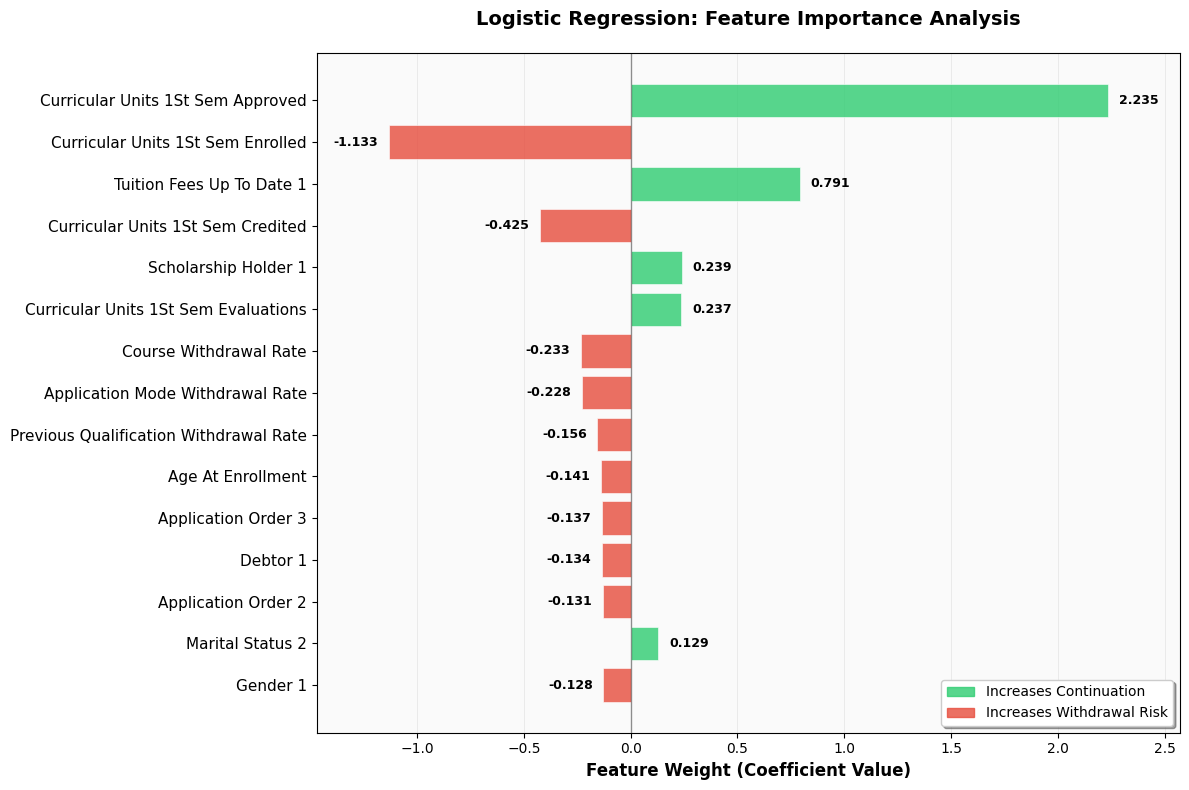

In [ ]:
def plot_feature_importance(feature_df, top_n=15):
    """Professional bar chart of feature importance."""

    
    # Get top N features
    top_features = feature_df.head(top_n)
    
    # Create figure with professional styling
    plt.figure(figsize=(12, 8))
    
    # Define colors: red for withdrawal risk, green for continuation
    colors = ['#E74C3C' if w < 0 else '#2ECC71' for w in top_features['weight']]
    
    # Create horizontal bar chart
    bars = plt.barh(range(len(top_features)), top_features['weight'], 
                    color=colors, alpha=0.8, edgecolor='white', linewidth=0.5)
    
    # Calculate x-axis limits with 10% padding
    min_val = top_features['weight'].min()
    max_val = top_features['weight'].max()
    range_val = max_val - min_val
    x_min = min_val - (range_val * 0.1)
    x_max = max_val + (range_val * 0.1)
    plt.xlim(x_min, x_max)
    
    # Format feature names: replace '_' with ' ' and title case
    formatted_labels = [feature.replace('_', ' ').title() for feature in top_features['feature']]
    
    # Styling
    plt.yticks(range(len(top_features)), formatted_labels, fontsize=11)
    plt.xlabel('Feature Weight (Coefficient Value)', fontsize=12, fontweight='bold')
    plt.title('Logistic Regression: Feature Importance Analysis', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Add zero line
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.4, linewidth=1)
    
    # Grid and layout
    plt.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
    plt.gca().set_axisbelow(True)
    plt.gca().invert_yaxis()
    plt.gca().set_facecolor('#FAFAFA')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_x = width + (0.05 if width >= 0 else -0.05)
        ha = 'left' if width >= 0 else 'right'
        plt.text(label_x, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha=ha, va='center', fontsize=9, fontweight='bold')
    
    # Legend
    
    green_patch = mpatches.Patch(color='#2ECC71', alpha=0.8, label='Increases Continuation')
    red_patch = mpatches.Patch(color='#E74C3C', alpha=0.8, label='Increases Withdrawal Risk')
    plt.legend(handles=[green_patch, red_patch], loc='lower right', 
               frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.show()

# Usage:
plot_feature_importance(feature_importance, top_n=15)

📋 Using threshold from config [pytorch_logistic_regression_testing]: 0.65

🔍 ERROR ANALYSIS SUMMARY
error_type
Correct                               757
False Negative (Missed Withdrawal)     68
False Positive (Wrong Flag)            60
Name: count, dtype: int64

❌ FALSE NEGATIVES: Withdrawals we MISSED
----------------------------------------
Count: 68 students

Characteristics of missed withdrawals:
• Average probability: 0.826
• Probability range: 0.663 - 0.971

Top feature comparison (missed vs average):
• Curricular Units 1St Sem Approved: 5.088 (avg: 4.739, diff: +0.349)
• Curricular Units 1St Sem Enrolled: 6.162 (avg: 6.244, diff: -0.082)
• Tuition Fees Up To Date 1: 1.000 (avg: 0.878, diff: +0.122)
• Curricular Units 1St Sem Credited: 0.647 (avg: 0.621, diff: +0.026)
• Scholarship Holder 1: 0.162 (avg: 0.240, diff: -0.078)

⚠️  FALSE POSITIVES: Students wrongly flagged as at-risk
--------------------------------------------------
Count: 60 students

Characteristics of wrongly f

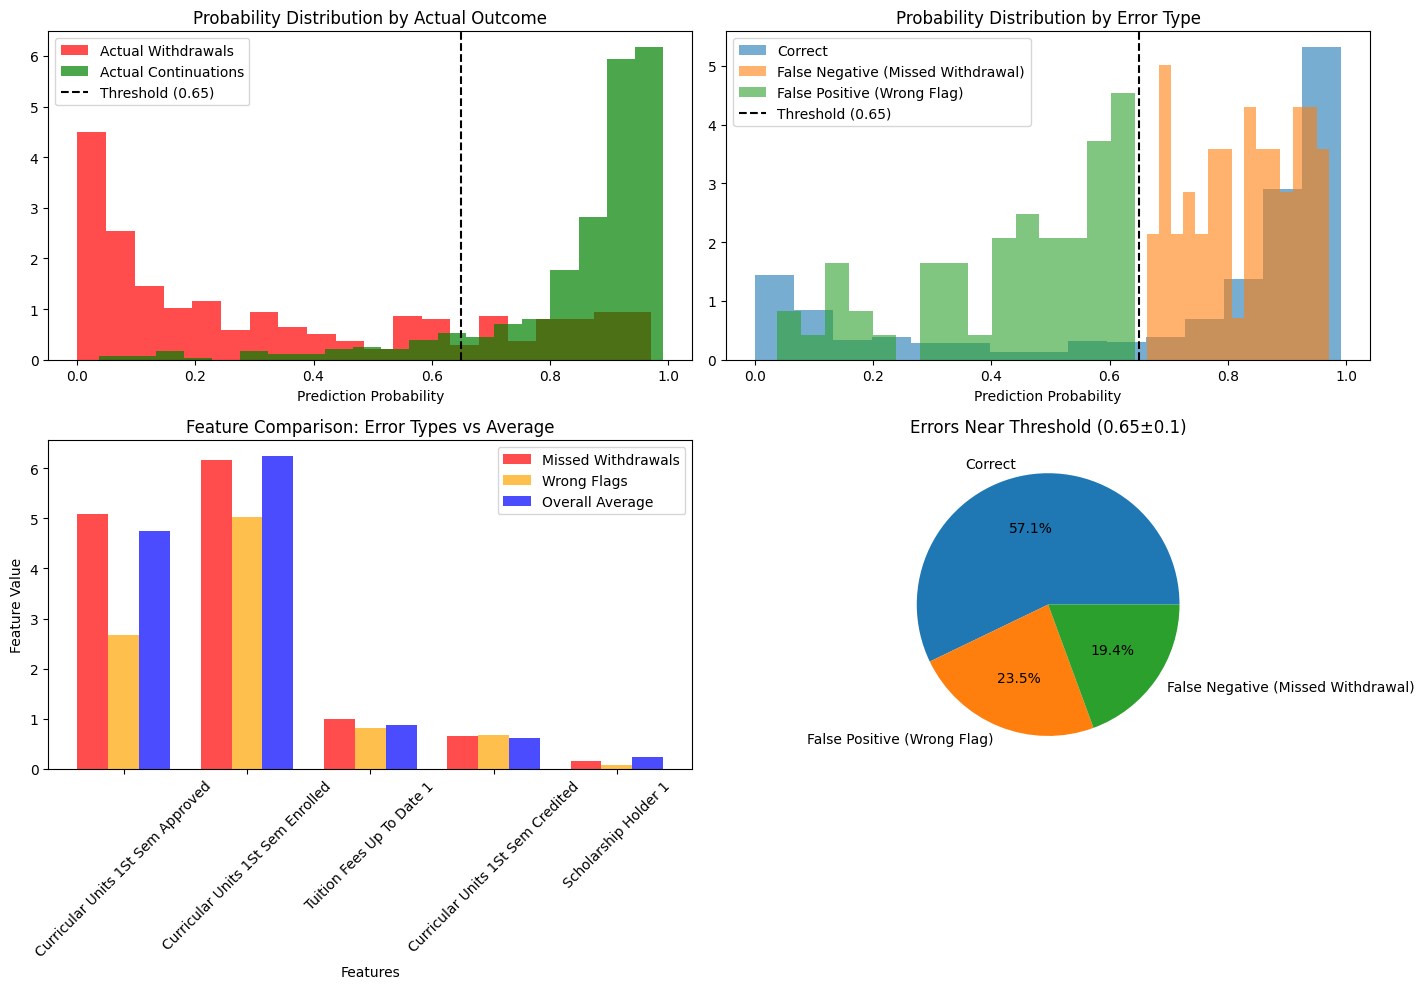

💡 IMPROVEMENT RECOMMENDATIONS
• Consider lowering threshold: 68 withdrawals had probability > 0.4
• Consider raising threshold: 60 wrong flags had probability < 0.7

📈 Feature insights for better withdrawal detection:
• Missed withdrawals have higher curricular units 1st sem approved
• Missed withdrawals have higher tuition fees up to date 1


In [ ]:
def comprehensive_error_analysis(y_test, predictions, probabilities, X_test, 
                               feature_importance, config, param_profile):
    """
    Comprehensive analysis of model errors to identify improvement opportunities.
    Threshold is pulled from config to ensure consistency.
    """
    
    # Get threshold from config (same pattern as rest of your code)
    threshold = config[param_profile].get('threshold', 0.5)
    print(f"📋 Using threshold from config [{param_profile}]: {threshold}")
    print()
    
    # Create analysis dataframe
    error_df = X_test.copy()
    error_df['actual'] = y_test
    error_df['predicted'] = predictions  
    error_df['probability'] = probabilities
    error_df['correct'] = (y_test == predictions)
    
    # Identify error types
    error_df['error_type'] = 'Correct'
    error_df.loc[(y_test == 0) & (predictions == 1), 'error_type'] = 'False Negative (Missed Withdrawal)'
    error_df.loc[(y_test == 1) & (predictions == 0), 'error_type'] = 'False Positive (Wrong Flag)'
    
    # Error counts
    print("🔍 ERROR ANALYSIS SUMMARY")
    print("=" * 50)
    error_counts = error_df['error_type'].value_counts()
    print(error_counts)
    print()
    
    # 1. FALSE NEGATIVES: Missed withdrawals (most critical)
    print("❌ FALSE NEGATIVES: Withdrawals we MISSED")
    print("-" * 40)
    false_negatives = error_df[error_df['error_type'] == 'False Negative (Missed Withdrawal)']
    print(f"Count: {len(false_negatives)} students")
    
    if len(false_negatives) > 0:
        print("\nCharacteristics of missed withdrawals:")
        print(f"• Average probability: {false_negatives['probability'].mean():.3f}")
        print(f"• Probability range: {false_negatives['probability'].min():.3f} - {false_negatives['probability'].max():.3f}")
        
        # Top features for missed withdrawals
        top_features = feature_importance['feature'].head(10).tolist()
        missed_profile = false_negatives[top_features].mean()
        overall_profile = error_df[top_features].mean()
        
        print(f"\nTop feature comparison (missed vs average):")
        for feature in top_features[:5]:
            missed_val = missed_profile[feature]
            overall_val = overall_profile[feature]
            diff = missed_val - overall_val
            print(f"• {feature.replace('_', ' ').title()}: {missed_val:.3f} (avg: {overall_val:.3f}, diff: {diff:+.3f})")
    
    print("\n" + "="*70)
    
    # 2. FALSE POSITIVES: Wrong flags
    print("⚠️  FALSE POSITIVES: Students wrongly flagged as at-risk")
    print("-" * 50)
    false_positives = error_df[error_df['error_type'] == 'False Positive (Wrong Flag)']
    print(f"Count: {len(false_positives)} students")
    
    if len(false_positives) > 0:
        print(f"\nCharacteristics of wrongly flagged students:")
        print(f"• Average probability: {false_positives['probability'].mean():.3f}")
        print(f"• Probability range: {false_positives['probability'].min():.3f} - {false_positives['probability'].max():.3f}")
        
        # Profile of false positives
        flagged_profile = false_positives[top_features].mean()
        
        print(f"\nTop feature comparison (wrongly flagged vs average):")
        for feature in top_features[:5]:
            flagged_val = flagged_profile[feature]
            overall_val = overall_profile[feature]
            diff = flagged_val - overall_val
            print(f"• {feature.replace('_', ' ').title()}: {flagged_val:.3f} (avg: {overall_val:.3f}, diff: {diff:+.3f})")
    
    print("\n" + "="*70)
    
    # 3. PROBABILITY DISTRIBUTION ANALYSIS
    print("📊 PROBABILITY DISTRIBUTION BY OUTCOME")
    print("-" * 40)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Probability distribution by actual outcome
    axes[0,0].hist(error_df[error_df['actual']==0]['probability'], bins=20, alpha=0.7, 
                   label='Actual Withdrawals', color='red', density=True)
    axes[0,0].hist(error_df[error_df['actual']==1]['probability'], bins=20, alpha=0.7, 
                   label='Actual Continuations', color='green', density=True)
    axes[0,0].axvline(threshold, color='black', linestyle='--', label=f'Threshold ({threshold})')
    axes[0,0].set_title('Probability Distribution by Actual Outcome')
    axes[0,0].set_xlabel('Prediction Probability')
    axes[0,0].legend()
    
    # Plot 2: Error types by probability
    for error_type in error_df['error_type'].unique():
        subset = error_df[error_df['error_type'] == error_type]
        if len(subset) > 0:
            axes[0,1].hist(subset['probability'], bins=15, alpha=0.6, 
                          label=error_type, density=True)
    axes[0,1].axvline(threshold, color='black', linestyle='--', label=f'Threshold ({threshold})')
    axes[0,1].set_title('Probability Distribution by Error Type')
    axes[0,1].set_xlabel('Prediction Probability')
    axes[0,1].legend()
    
    # Plot 3: Key feature comparison
    if len(false_negatives) > 0 and len(false_positives) > 0:
        comparison_features = top_features[:5]
        x_pos = np.arange(len(comparison_features))
        
        missed_vals = [missed_profile[f] for f in comparison_features]
        flagged_vals = [flagged_profile[f] for f in comparison_features]
        overall_vals = [overall_profile[f] for f in comparison_features]
        
        width = 0.25
        axes[1,0].bar(x_pos - width, missed_vals, width, label='Missed Withdrawals', color='red', alpha=0.7)
        axes[1,0].bar(x_pos, flagged_vals, width, label='Wrong Flags', color='orange', alpha=0.7)
        axes[1,0].bar(x_pos + width, overall_vals, width, label='Overall Average', color='blue', alpha=0.7)
        
        axes[1,0].set_xlabel('Features')
        axes[1,0].set_ylabel('Feature Value')
        axes[1,0].set_title('Feature Comparison: Error Types vs Average')
        axes[1,0].set_xticks(x_pos)
        axes[1,0].set_xticklabels([f.replace('_', ' ').title() for f in comparison_features], rotation=45)
        axes[1,0].legend()
    
    # Plot 4: Confusion in probability space
    threshold_area = 0.1  # ±0.1 around threshold
    near_threshold = error_df[
        (error_df['probability'] >= threshold - threshold_area) & 
        (error_df['probability'] <= threshold + threshold_area)
    ]
    
    if len(near_threshold) > 0:
        confusion_counts = near_threshold['error_type'].value_counts()
        axes[1,1].pie(confusion_counts.values, labels=confusion_counts.index, autopct='%1.1f%%')
        axes[1,1].set_title(f'Errors Near Threshold ({threshold}±{threshold_area})')
    
    plt.tight_layout()
    plt.show()
    
    # 4. IMPROVEMENT RECOMMENDATIONS
    print("💡 IMPROVEMENT RECOMMENDATIONS")
    print("=" * 50)
    
    if len(false_negatives) > 0:
        high_prob_misses = false_negatives[false_negatives['probability'] > 0.4]
        print(f"• Consider lowering threshold: {len(high_prob_misses)} withdrawals had probability > 0.4")
    
    if len(false_positives) > 0:
        low_prob_flags = false_positives[false_positives['probability'] < 0.7]
        print(f"• Consider raising threshold: {len(low_prob_flags)} wrong flags had probability < 0.7")
    
    # Feature insights
    if len(false_negatives) > 0:
        print(f"\n📈 Feature insights for better withdrawal detection:")
        for feature in top_features[:3]:
            missed_val = missed_profile[feature]
            overall_val = overall_profile[feature]
            if abs(missed_val - overall_val) > 0.1:
                direction = "higher" if missed_val > overall_val else "lower"
                print(f"• Missed withdrawals have {direction} {feature.replace('_', ' ')}")
    
    return error_df

# Run the analysis using your existing config pattern
param_profile = 'pytorch_logistic_regression_testing'
error_analysis_df = comprehensive_error_analysis(
    y_test, predictions, probabilities, X_test, 
    feature_importance, config, param_profile
)